# Map Ensembl IDs to Gene Names

This notebook maps Ensembl gene IDs from Homer motif analysis results to gene names using the Ensembl REST API.

## Files to process:
- `motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords.tsv`
- `motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords_unique.tsv`

## 1. Import Required Libraries

In [1]:
import pandas as pd
import requests
import time
from typing import Dict, List
import json

## 2. Load the TSV Data

In [2]:
# Load both TSV files
file1 = 'motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords.tsv'
file2 = 'motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords_unique.tsv'

df1 = pd.read_csv(file1, sep='\t')
df2 = pd.read_csv(file2, sep='\t')

print(f"File 1: {file1}")
print(f"Shape: {df1.shape}")
print(f"\nFirst few rows:")
print(df1.head())
print(f"\n" + "="*80)
print(f"\nFile 2: {file2}")
print(f"Shape: {df2.shape}")
print(f"\nFirst few rows:")
print(df2.head())

FileNotFoundError: [Errno 2] No such file or directory: 'motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords.tsv'

## 3. Extract Unique Ensembl IDs

In [ ]:
# Extract Ensembl IDs from both files (gene column format: >ENSGALG00010029584 upstream 2000bp)
def extract_ensembl_id(gene_str):
    """Extract Ensembl ID from gene column string"""
    # Remove '>' and split by space to get the ID
    return gene_str.replace('>', '').split()[0]

# Get unique Ensembl IDs from both files
ensembl_ids_1 = df1['gene'].apply(extract_ensembl_id).unique()
ensembl_ids_2 = df2['gene'].apply(extract_ensembl_id).unique()

# Combine and get all unique IDs
all_ensembl_ids = list(set(list(ensembl_ids_1) + list(ensembl_ids_2)))

print(f"Total unique Ensembl IDs to map: {len(all_ensembl_ids)}")
print(f"\nExample IDs:")
for i, eid in enumerate(all_ensembl_ids[:5]):
    print(f"  {i+1}. {eid}")

## 4. Query Ensembl Database for Gene Names

Using the Ensembl REST API to fetch gene names for chicken (Gallus gallus) genes.

In [ ]:
def get_gene_name_from_ensembl(ensembl_id: str) -> str:
    """
    Query Ensembl REST API to get gene name for a given Ensembl ID
    """
    server = "https://rest.ensembl.org"
    ext = f"/lookup/id/{ensembl_id}?"

    try:
        response = requests.get(server + ext, headers={"Content-Type": "application/json"})

        if response.ok:
            data = response.json()
            # Try to get display_name (gene symbol), fallback to description or ID
            gene_name = data.get('display_name') or data.get('description') or ensembl_id
            return gene_name
        else:
            return ensembl_id  # Return ID if lookup fails
    except Exception as e:
        print(f"Error fetching {ensembl_id}: {e}")
        return ensembl_id

def batch_query_ensembl(ensembl_ids: List[str], delay: float = 0.1) -> Dict[str, str]:
    """
    Query Ensembl for multiple IDs with rate limiting
    """
    mapping = {}
    total = len(ensembl_ids)

    print(f"Querying Ensembl for {total} IDs...")
    print("This may take a few minutes...")

    for i, eid in enumerate(ensembl_ids, 1):
        gene_name = get_gene_name_from_ensembl(eid)
        mapping[eid] = gene_name

        # Progress indicator
        if i % 10 == 0 or i == total:
            print(f"  Progress: {i}/{total} ({i/total*100:.1f}%)")

        # Rate limiting - be respectful to the API
        time.sleep(delay)

    print("✓ Query complete!")
    return mapping

# Query all Ensembl IDs
ensembl_to_gene = batch_query_ensembl(all_ensembl_ids)

In [ ]:
# Display sample mappings
print("Sample mappings:")
print("="*80)
for i, (ensembl_id, gene_name) in enumerate(list(ensembl_to_gene.items())[:10]):
    print(f"{ensembl_id} → {gene_name}")

# Count how many were successfully mapped
mapped_count = sum(1 for eid, name in ensembl_to_gene.items() if name != eid)
print(f"\n✓ Successfully mapped: {mapped_count}/{len(ensembl_to_gene)} ({mapped_count/len(ensembl_to_gene)*100:.1f}%)")

## 5. Map Gene Names to Original Data

In [ ]:
# Add gene_name column to both dataframes
def add_gene_name_column(df, mapping):
    """Add gene_name column based on Ensembl ID mapping"""
    df['ensembl_id'] = df['gene'].apply(extract_ensembl_id)
    df['gene_name'] = df['ensembl_id'].map(mapping)
    return df

df1_mapped = add_gene_name_column(df1.copy(), ensembl_to_gene)
df2_mapped = add_gene_name_column(df2.copy(), ensembl_to_gene)

# Reorder columns to put gene_name after gene
cols1 = df1_mapped.columns.tolist()
cols1.remove('gene_name')
cols1.remove('ensembl_id')
cols1.insert(cols1.index('gene') + 1, 'ensembl_id')
cols1.insert(cols1.index('ensembl_id') + 1, 'gene_name')
df1_mapped = df1_mapped[cols1]

cols2 = df2_mapped.columns.tolist()
cols2.remove('gene_name')
cols2.remove('ensembl_id')
cols2.insert(cols2.index('gene') + 1, 'ensembl_id')
cols2.insert(cols2.index('ensembl_id') + 1, 'gene_name')
df2_mapped = df2_mapped[cols2]

print("File 1 with gene names:")
print(df1_mapped.head(10))
print(f"\n{'='*80}\n")
print("File 2 with gene names:")
print(df2_mapped.head(10))

## 6. Save Results to Output Files

In [ ]:
# Save mapped files
output_file1 = 'motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords.tsv'
output_file2 = 'motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords_unique.tsv'
mapping_file = 'motif_ISG_vs_nonISG/motif_hits/ensembl_to_gene_mapping.tsv'

# Save the enriched data
df1_mapped.to_csv(output_file1, sep='\t', index=False)
df2_mapped.to_csv(output_file2, sep='\t', index=False)

print(f"✓ Saved: {output_file1}")
print(f"✓ Saved: {output_file2}")

# Save the mapping separately
mapping_df = pd.DataFrame(list(ensembl_to_gene.items()), columns=['ensembl_id', 'gene_name'])
mapping_df = mapping_df.sort_values('ensembl_id')
mapping_df.to_csv(mapping_file, sep='\t', index=False)
print(f"✓ Saved: {mapping_file}")
print(f"\n{'='*80}")
print("Summary:")
print(f"  - File 1: {df1_mapped.shape[0]} rows")
print(f"  - File 2: {df2_mapped.shape[0]} rows")
print(f"  - Unique genes mapped: {len(ensembl_to_gene)}")

In [2]:
# Quick reload: Load the saved TSV files with gene names already mapped
# Use this cell to skip the API query steps above

import pandas as pd

# Load the saved files
df1_mapped = pd.read_csv('motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords.tsv', sep='\t')
df2_mapped = pd.read_csv('motif_ISG_vs_nonISG/motif_hits/homerMotifs.all_coords_unique.tsv', sep='\t')

print(f"✓ Loaded df1_mapped: {df1_mapped.shape}")
print(f"✓ Loaded df2_mapped: {df2_mapped.shape}")
print(f"\nColumns: {list(df2_mapped.columns)}")
print(f"\nFirst few rows:")
print(df2_mapped.head())

✓ Loaded df1_mapped: (9517, 9)
✓ Loaded df2_mapped: (8748, 9)

Columns: ['motif', 'gene', 'ensembl_id', 'gene_name', 'start', 'end', 'strand', 'score', 'reverse']

First few rows:
        motif                                gene          ensembl_id  \
0  1-AAAGATCT  ENSGALG00010001479 upstream 2000bp  ENSGALG00010001479   
1  1-AAAGATCT  ENSGALG00010001556 upstream 2000bp  ENSGALG00010001556   
2  1-AAAGATCT  ENSGALG00010001556 upstream 2000bp  ENSGALG00010001556   
3  1-AAAGATCT  ENSGALG00010002359 upstream 2000bp  ENSGALG00010002359   
4  1-AAAGATCT  ENSGALG00010002359 upstream 2000bp  ENSGALG00010002359   

  gene_name  start   end strand      score   reverse  
0   TMEM168   1056  1063      +   9.285433  AAGGATCT  
1   EPB41L3    559   566      +  10.370729  AAAGATCT  
2   EPB41L3    561   568      -  10.370729  AGATCTTT  
3     CMTM6    285   292      -  10.370729  AGATCTTT  
4     CMTM6    328   335      +  10.370729  AAAGATCT  


## 7. Create Gene-Motif Heatmap

Visualize the occurrence of motifs across genes using a heatmap.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the number of top motifs to display
TOP_N_MOTIFS = 20  # Change this value to show more or fewer motifs

# Create a pivot table: rows = gene_name, columns = motif, values = count
heatmap_data_full = df2_mapped.groupby(['gene_name', 'motif']).size().unstack(fill_value=0)

# Get the top N most frequent motifs (by total occurrences across all genes)
motif_totals = heatmap_data_full.sum(axis=0).sort_values(ascending=False)
top_motifs = motif_totals.head(TOP_N_MOTIFS).index

# Filter the heatmap to show only top motifs
heatmap_data = heatmap_data_full[top_motifs]

print(f"Full dataset: {heatmap_data_full.shape[0]} genes × {heatmap_data_full.shape[1]} motifs")
print(f"Filtered to top {TOP_N_MOTIFS} motifs")
print(f"Heatmap dimensions: {heatmap_data.shape[0]} genes × {heatmap_data.shape[1]} motifs")
print(f"\nTop {min(10, TOP_N_MOTIFS)} most frequent motifs:")
for i, (motif, count) in enumerate(motif_totals.head(10).items(), 1):
    print(f"  {i}. {motif}: {count} occurrences")
print(f"\nFirst few rows and columns:")
print(heatmap_data.iloc[:5, :5])

Full dataset: 139 genes × 268 motifs
Filtered to top 20 motifs
Heatmap dimensions: 139 genes × 20 motifs

Top 10 most frequent motifs:
  1. 171-ATATATATATAT: 593 occurrences
  2. 77-TCTTCTCTTC: 557 occurrences
  3. 19-TCTCCTCT: 479 occurrences
  4. 4-CGCGGCAC: 190 occurrences
  5. 16-CCGCCCCGCT: 172 occurrences
  6. 3-CCWGGYTG: 148 occurrences
  7. 15-NCTGCCCN: 129 occurrences
  8. 7-CGCCCCGC: 124 occurrences
  9. 27-SSTGCCBTGC: 108 occurrences
  10. 11-CAGCGCTT: 105 occurrences

First few rows and columns:
motif      171-ATATATATATAT  77-TCTTCTCTTC  19-TCTCCTCT  4-CGCGGCAC  \
gene_name                                                             
ACKR4                     7              3            2           0   
ADAR                      0              6            3           2   
ANGPT1                    0              3            4           0   
ANGPTL1                   4              3            2           0   
ANKFN1                    1              4            3      

**Note on occurrence counts:**
- The "top motifs" are ranked by **total occurrences across all genes** (e.g., a motif appearing 593 times total)
- The heatmap cells show **occurrences per individual gene** (e.g., that same motif might appear 50 times in one specific gene)
- So a motif with 593 total occurrences is distributed across many genes, with varying counts per gene

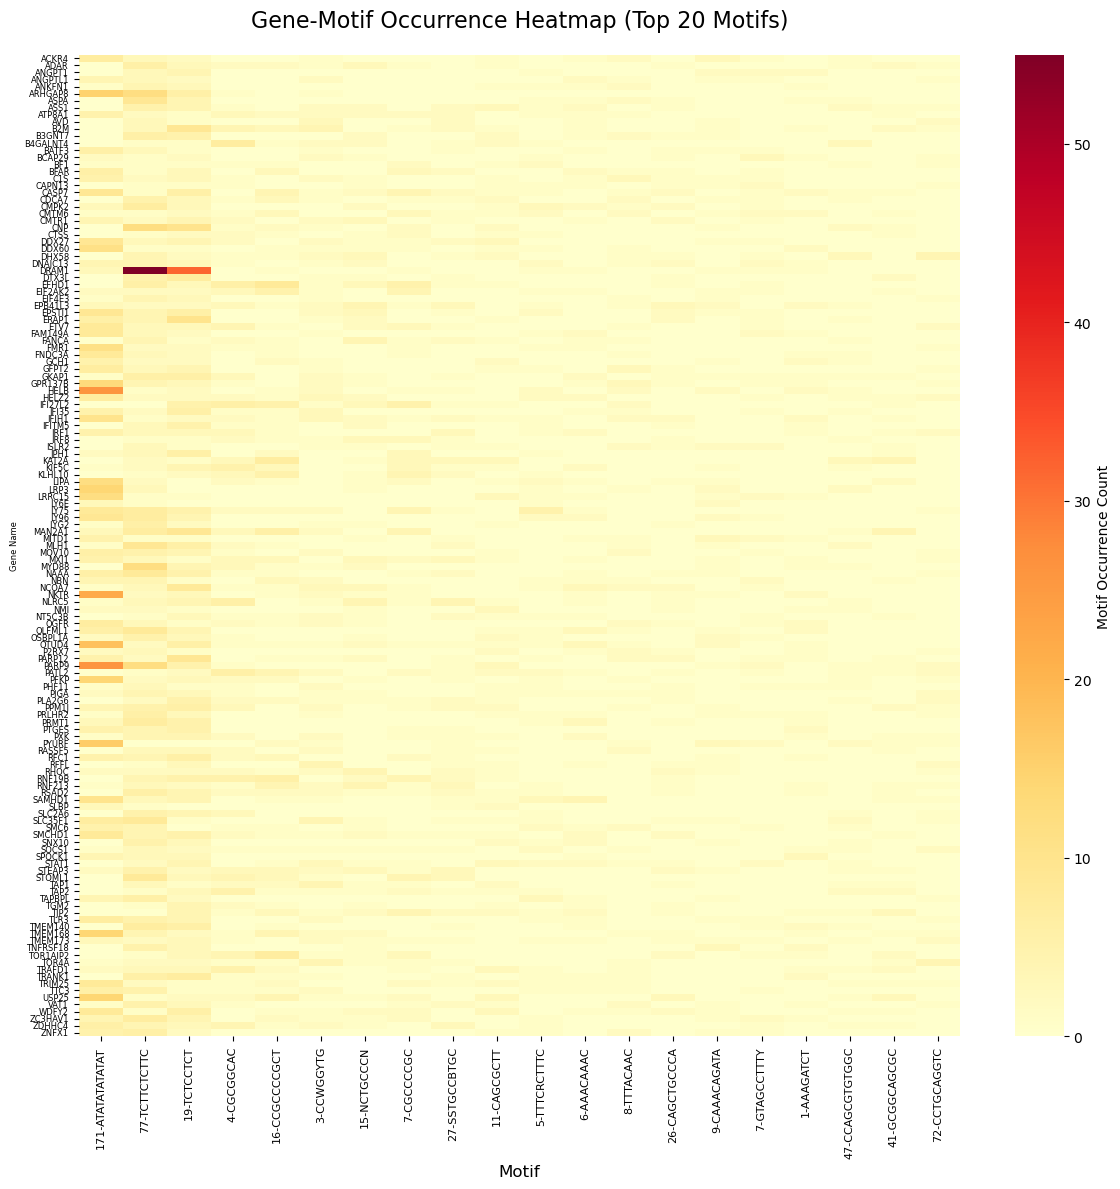


Heatmap Statistics:
  - Total genes: 139
  - Motifs shown: 20 (top 20)
  - Max occurrence: 55
  - Mean occurrence (excluding zeros): 2.01
  - Sparsity: 48.4% zeros


In [7]:
# Create the heatmap
fig_width = min(20, max(12, TOP_N_MOTIFS * 0.3))  # Adjust width based on number of motifs
plt.figure(figsize=(fig_width, 12))

# Use a color map that shows 0 as white and higher values with color intensity
sns.heatmap(heatmap_data,
            cmap='YlOrRd',  # Yellow-Orange-Red colormap
            cbar_kws={'label': 'Motif Occurrence Count'},
            linewidths=0,
            square=False,
            xticklabels=True,
            yticklabels=True)

plt.title(f'Gene-Motif Occurrence Heatmap (Top {TOP_N_MOTIFS} Motifs)', fontsize=16, pad=20)
plt.xlabel('Motif', fontsize=12)
plt.ylabel('Gene Name', fontsize=6)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

# Show some statistics
print(f"\nHeatmap Statistics:")
print(f"  - Total genes: {heatmap_data.shape[0]}")
print(f"  - Motifs shown: {heatmap_data.shape[1]} (top {TOP_N_MOTIFS})")
print(f"  - Max occurrence: {heatmap_data.max().max()}")
print(f"  - Mean occurrence (excluding zeros): {heatmap_data[heatmap_data > 0].mean().mean():.2f}")
print(f"  - Sparsity: {(heatmap_data == 0).sum().sum() / (heatmap_data.shape[0] * heatmap_data.shape[1]) * 100:.1f}% zeros")

### Alternative: Interactive Plotly Heatmap

For a more interactive experience with zoom and hover information:

In [8]:
import plotly.express as px

# Create interactive heatmap with top motifs
fig = px.imshow(heatmap_data,
                labels=dict(x="Motif", y="Gene Name", color="Occurrence Count"),
                x=heatmap_data.columns,
                y=heatmap_data.index,
                color_continuous_scale='YlOrRd',
                aspect='auto',
                title=f'Interactive Gene-Motif Occurrence Heatmap (Top {TOP_N_MOTIFS} Motifs)')

fig.update_xaxes(side="bottom", tickangle=90)
fig.update_layout(
    width=min(1600, max(1000, TOP_N_MOTIFS * 20)),  # Adjust width based on motif count
    height=800,
    xaxis={'tickfont': {'size': 8}},
    yaxis={'tickfont': {'size': 6}}  # Reduced from 8 to 6 for gene names
)

fig.show()

# Export to HTML for standalone viewing
output_heatmap = f'motif_gene_heatmap_top{TOP_N_MOTIFS}.html'
fig.write_html(output_heatmap)
print(f"\n✓ Interactive heatmap saved to: {output_heatmap}")
print(f"   (Showing top {TOP_N_MOTIFS} most frequent motifs out of {heatmap_data_full.shape[1]} total)")


✓ Interactive heatmap saved to: motif_gene_heatmap_top20.html
   (Showing top 20 most frequent motifs out of 268 total)
